<a href="https://colab.research.google.com/github/mikolaj553/Machine-Learning-Homeworks-Repo/blob/main/ml_hw9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Homework #9 - Mikołaj Kowalewski, lab group no. 1**

---
# Task 1
**Generate a batch of 10 dreamed MNIST digits**

In this task, we optimize a batch of 10 input images (initialized as random Gaussian noise) so that a frozen, pretrained MNIST classifier will assign each image a target digit from 0 to 9.


In [ ]:
# Imports & device setup
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



To get identical results across sessions (same model weights, same initial noise, same optimization path), we will fix the random seed for Python, NumPy, and PyTorch, and enforce deterministic CUDA behavior.


In [ ]:
# 1) Python RNG
random.seed(42)
# 2) NumPy RNG
np.random.seed(42)
# 3) PyTorch RNG (both CPU and CUDA)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 4) Enforcing deterministic CuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Training a simple MNIST classifier, then freezing its weights

class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, 5), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16*4*4, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )
    def forward(self, x):
        return self.net(x)

model = MNISTClassifier().to(device)
train_ds = MNIST(root='.', train=True, download=True,
                 transform=transforms.ToTensor())
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 4):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} — avg loss: {avg:.4f}")

model.eval()
for param in model.parameters():
    param.requires_grad = False
print("Model in eval mode; weights frozen")



Epoch 1 — avg loss: 0.5226
Epoch 2 — avg loss: 0.0846
Epoch 3 — avg loss: 0.0594
Model in eval mode; weights frozen


We now create 10 images of shape 1×28×28, each initialized from a Gaussian distribution.

In [125]:
# Reproducible noise init + targets
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

batch_size = 10
dreamed = torch.randn(
    batch_size, 1, 28, 28,
    device=device,
    requires_grad=True
)
targets = torch.arange(batch_size, device=device)  # labels 0…9



We will now fllow this the four-step process:

1. Start with the noise batch and target labels (0–9).  
2. Define the objective: maximize the network’s confidence for each image’s target digit (minimize cross-entropy).  
3. Use gradient descent (Adam) to update the input pixels.  
4. Repeat until each image’s predicted probability ≥ 0.99 or a max iteration limit.

In [121]:
optimizer    = torch.optim.Adam([dreamed], lr=0.01)
max_iters    = 1000
threshold    = 0.99

snapshots    = []
conf_history = []

for i in range(1, max_iters+1):
    # 1) forward & backward
    optimizer.zero_grad()
    logits = model(dreamed)
    loss   = F.cross_entropy(logits, targets)
    loss.backward()
    optimizer.step()
    dreamed.data.clamp_(0, 1)

    # 2) recompute logits & confidences on updated inputs
    with torch.no_grad():
        new_logits = model(dreamed)
        probs      = F.softmax(new_logits, dim=1)
        confs      = probs[range(batch_size), targets]

    # 3) record this iteration’s inputs & confidences
    snapshots.append(dreamed.detach().cpu().clone())
    conf_history.append(confs.cpu())

    # 4) stopping check
    if torch.all(confs >= threshold):
        final_iter = i
        print(f"Reached {threshold*100:.0f}% confidence at iter {i}")
        break
else:
    final_iter = max_iters
    print("Max iterations reached without full confidence.")

snapshots    = snapshots[:final_iter]
conf_history = conf_history[:final_iter]


Reached 99% confidence at iter 228


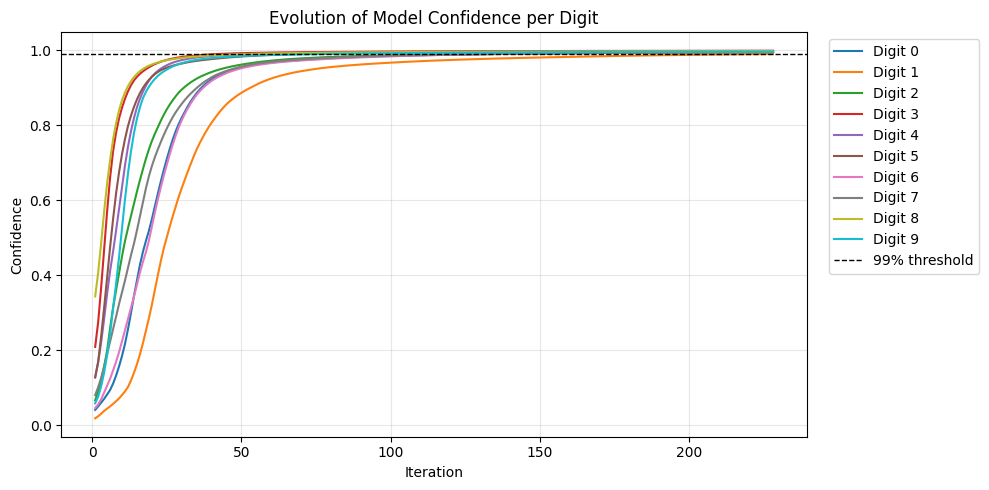

In [122]:
conf_array = torch.stack(conf_history).cpu().numpy()  # shape [228, batch]
iters       = np.arange(1, conf_array.shape[0] + 1)

plt.figure(figsize=(10, 5))
for d in range(batch_size):
    plt.plot(iters, conf_array[:, d], label=f'Digit {d}')
plt.axhline(threshold, color='black', linestyle='--', linewidth=1,
            label=f'{int(threshold*100)}% threshold')
plt.xlabel('Iteration')
plt.ylabel('Confidence')
plt.title('Evolution of Model Confidence per Digit')
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

We sample 25 snapshots (including the very first and very last) evenly across all iterations. Above each row of 10 images we show the current iteration number, the digit predicted, and the confidence level.


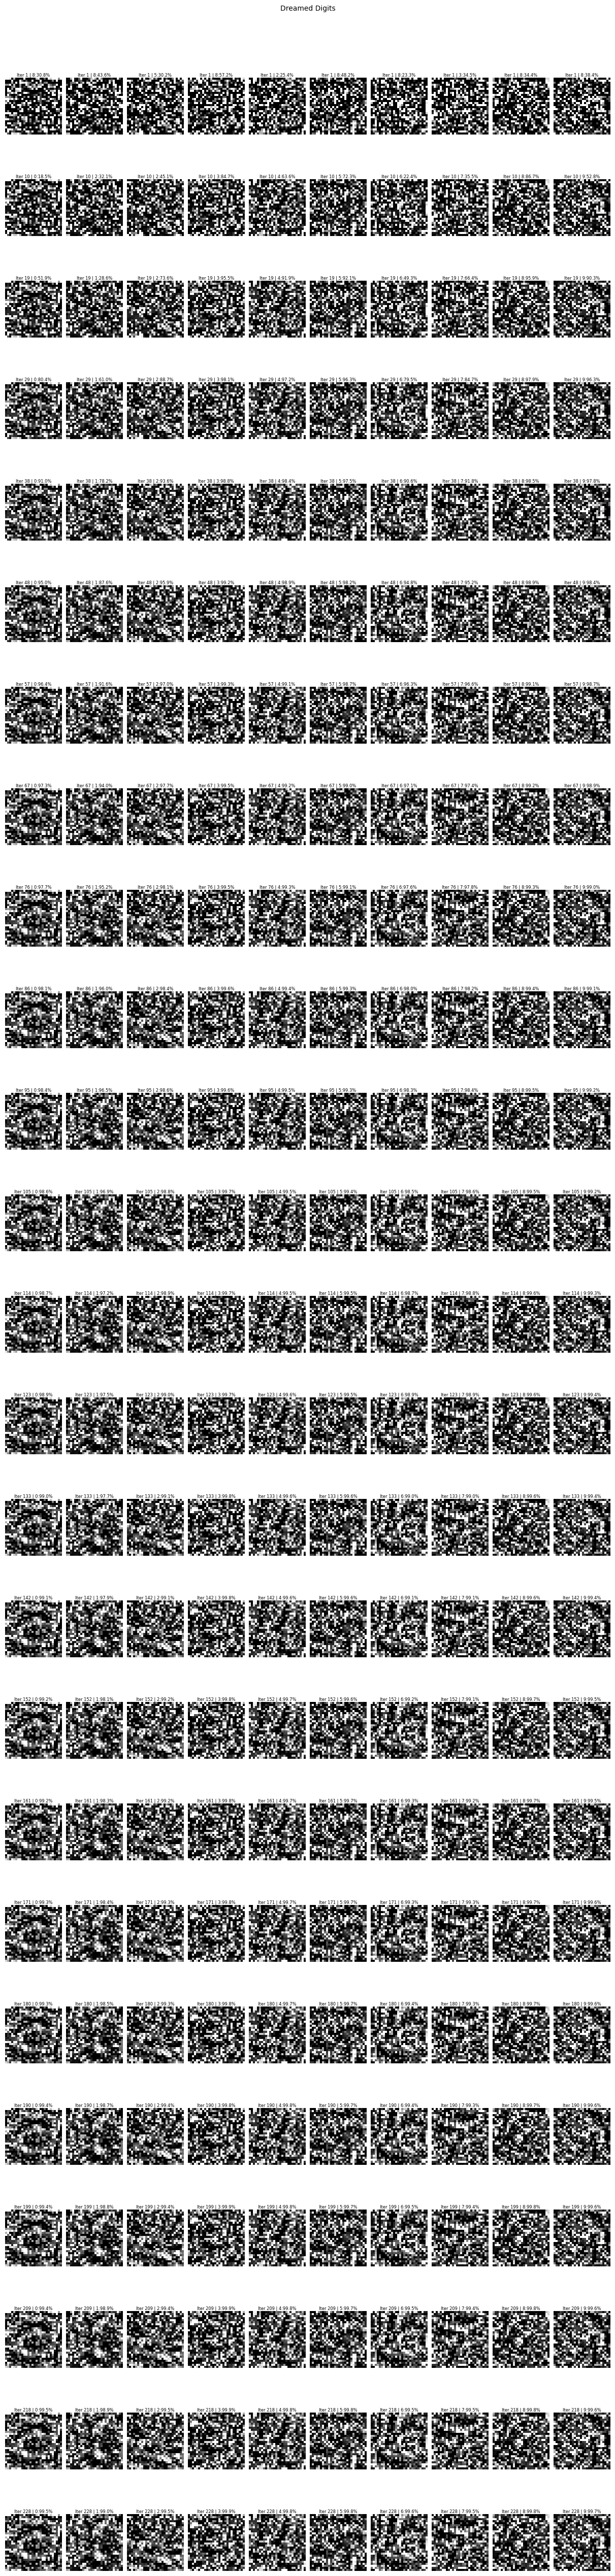

In [123]:
# 1) Recomputing display_snaps, display_iters, display_preds, display_confs if needed
num_display   = min(25, len(snapshots))
total_steps   = len(snapshots)
idxs          = np.linspace(0, total_steps - 1, num_display, dtype=int)
display_snaps = [snapshots[i] for i in idxs]
display_iters = [i + 1 for i in idxs]

model.eval()
display_preds = []
display_confs = []
with torch.no_grad():
    for snap in display_snaps:
        logits = model(snap.to(device))
        probs  = F.softmax(logits, dim=1)
        confs, preds = probs.max(dim=1)
        display_confs.append(confs.cpu().numpy())
        display_preds.append(preds.cpu().numpy())

# 2) Plotting grid with titles above each image
fig, axes = plt.subplots(
    num_display, batch_size,
    figsize=(12, 2 * num_display),
    constrained_layout=True
)

for row, (snap, it) in enumerate(zip(display_snaps, display_iters)):
    for col in range(batch_size):
        ax = axes[row, col]
        ax.imshow(snap[col].squeeze(), cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
        pred = display_preds[row][col]
        conf = display_confs[row][col]
        ax.set_title(f"Iter {it} | {pred}:{conf*100:.1f}%", fontsize=6, pad=2)

plt.suptitle('Dreamed Digits', y=1.02, fontsize=10)
plt.show()

## Question: Do the generated images resemble real MNIST digits?

The images produced by our “dream” optimization do not look like genuine handwritten digits. Even though the classifier assigns them over 99 % confidence, they appear as high-frequency speckled patterns rather than smooth strokes. This happens because we are directly tuning pixel values to maximally excite the network’s internal feature detectors, without any constraint to preserve the global shapes or continuity of a human‐drawn digit. In the absence of a regularizer (such as an L₂ penalty, for instance), the optimizer simply amplifies tiny local patterns that trigger the classifier, resulting in adversarial-like noise, rather than genuine digits.

---
# Task 2
**Generate an image that resembles two (or more) digits simultaneously**

In this task, we treat a single 28×28 grayscale image as the only trainable variable, starting from pure random noise and aiming to activate multiple digit classes simultaneously (for example, 3 and 8). We construct a multi-hot target vector with ones at the indices of the desired digits and zeros elsewhere. Rather than using a softmax — which forces class probabilities to sum to one and prevents more than one class from dominating — we apply a per-class sigmoid to each logit and optimize a binary cross-entropy loss (`BCEWithLogitsLoss`) against our multi-hot labels. This loss treats each digit independently, allowing us to push the network’s confidence in each selected class toward 1. We use an Adam optimizer to backpropagate gradients into the pixel values, clamping the image into [0, 1] after every update. Repeating this process turns the noise into a pattern that the frozen MNIST classifier recognizes simultaneously as all of our target digits.

Because we use a per-class sigmoid and BCE loss rather than a softmax, this pipeline generalizes directly to any number of target classes. To blend three, four, or more digits, it is sufficient to set ones in the label vector for each desired class and run the same optimization. We demonstrate the code for two digits below.

In [86]:
# 1) Specifying target digits
target_digits = [3, 8]           #we blend digit 3 and 8
num_classes   = 10

# 2) Initializing image & labels
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

dreamed = torch.randn(1, 1, 28, 28, device=device, requires_grad=True)

# multi-hot labels: 1 for targets, 0 otherwise
labels = torch.zeros(num_classes, device=device)
labels[target_digits] = 1.0        # e.g. [0,0,0,1,0,0,0,0,1,0]

# 3) Setup optimizer & loss
optimizer = torch.optim.Adam([dreamed], lr=0.01)
bce_loss  = torch.nn.BCEWithLogitsLoss()
max_iters = 1000
threshold = 0.99

# 4) Optimization loop
for i in range(1, max_iters+1):
    optimizer.zero_grad()
    logits = model(dreamed).squeeze(0)         # shape [10]
    loss   = bce_loss(logits, labels)         # binary cross‐entropy on each logit
    loss.backward()
    optimizer.step()
    dreamed.data.clamp_(0, 1)

    # check per‐class sigmoid confidences
    with torch.no_grad():
        probs = torch.sigmoid(logits)         # independent probabilities
        confs = probs[target_digits]

    if (confs >= threshold).all():
        print(f"Iteration {i}: reached {threshold*100:.0f}% for {target_digits}")
        break
else:
    print(f"Stopped at {max_iters} iters; confidences =",
          {d: f"{probs[d]*100:.1f}%" for d in target_digits})


Iteration 42: reached 99% for [3, 8]


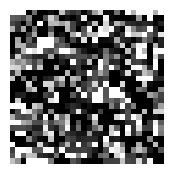

{3: '99.1%', 8: '99.3%'}


In [87]:
plt.figure(figsize=(2,2))
plt.imshow(dreamed.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.show()

with torch.no_grad():
    final_probs = torch.sigmoid(model(dreamed).squeeze(0))
print({d: f"{final_probs[d]*100:.1f}%" for d in target_digits})


 After a few hundred iterations the network assigns this image 99.1 % confidence for digit 3 and 99.3 % for digit 8. Although the final pattern still looks like high-frequency noise to a human, it successfully activates the learned feature detectors for both target classes at the same time.

---
# Task 3
**Repeat the previous tasks with an additional L2 penalty on noise within the images**

We first repeat Task 1’s optimization with an additional $L_2$ penalty on the input pixels.  The loss for a batch of inputs $x\in\mathbb{R}^{B\times1\times28\times28}$ and corresponding target labels is

$$
\mathcal{L}(x)
= \underbrace{\mathrm{CE}\bigl(\mathrm{softmax}(\mathrm{model}(x)),\,\mathrm{targets}\bigr)}_{\text{cross-entropy}}
+ \lambda_{12}\,\underbrace{\frac{1}{B}\sum_{b=1}^B \bigl\lVert x_b\bigr\rVert_2^2}_{\text{mean }L_2\text{ penalty}}
$$

where $\lambda_{12}$ controls how strongly we discourage large pixel values.  We sweep

$$
\lambda_{12} \in \{0.001,\;0.01,\;0.1,\;1,\;10\},
$$

re-initializing the noise and running a fixed number of Adam steps for each value.


We reseed here to guarantee the same noise every run, then create 10 images of shape 1×28×28.

In [88]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

batch_size = 10
dreamed    = torch.randn(batch_size, 1, 28, 28,
                         device=device, requires_grad=True)
targets    = torch.arange(batch_size, device=device)  # 0…9

We minimize  
$$
\mathcal{L} = \mathrm{CE}\bigl(\mathrm{softmax}(\mathrm{model}(x)),\,\mathrm{targets}\bigr)
              + \lambda_{12}\,\frac{1}{B}\sum_{b=1}^B \lVert x_b\rVert_2^2
$$  
via Adam on the inputs, clamping $x\in[0,1]$ each step, and stopping when all confidences ≥ 99 % or after 1000 iterations, similarly to the first task, but with the additional penalty.


In [107]:
# 1) Hyperparameters & storage
batch_size    = 10
max_iters     = 1000
lr            = 0.01
lambda_values = np.logspace(-3, 1, 5)  # [0.001, 0.01, 0.1, 1, 10]
threshold     = 0.99
targets       = torch.arange(batch_size, device=device)

final_images    = []
final_confs     = []
end_iters       = []
all_snapshots   = []
all_snap_iters  = []
conf_histories  = []

# 2) Sweeping over L2 penalties grid
for lambda_12 in lambda_values:
    # 2.1) Reseed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # per‐λ storage
    snapshots   = []
    snap_iters  = []
    history     = []

    # 2.2) Initializing trainable noise batch
    dreamed   = torch.randn(batch_size, 1, 28, 28,
                             device=device, requires_grad=True)
    optimizer = torch.optim.Adam([dreamed], lr=lr)

    # 2.3) Optimizing with L2 penalty, snapshot every 25 steps, early stopping
    for it in range(1, max_iters+1):
        optimizer.zero_grad()
        logits  = model(dreamed)
        ce_loss = F.cross_entropy(logits, targets)
        l2_pen  = dreamed.pow(2).mean()
        loss    = ce_loss + lambda_12 * l2_pen
        loss.backward()
        optimizer.step()
        dreamed.data.clamp_(0, 1)

        # record confidences
        with torch.no_grad():
            probs = F.softmax(model(dreamed), dim=1)
            confs = probs[range(batch_size), targets]

        history.append(confs.cpu().numpy())

        # snapshot every 25 iterations
        if it % 25 == 0:
            snapshots.append(dreamed.detach().cpu().clone())
            snap_iters.append(it)

        # early stopping
        if torch.all(confs >= threshold):
            print(f"λ = {lambda_12:.3f}: reached {threshold*100:.0f}% at iter {it}")
            end_iters.append(it)
            break
    else:
        print(f"λ = {lambda_12:.3f}: stopped after {max_iters} iterations; final confidences =",
              {i: f"{confs[i]*100:.1f}%" for i in range(batch_size)})
        end_iters.append(max_iters)

    # 2.4) Record final results
    final_images.append(dreamed.detach().cpu())
    final_confs.append(confs.cpu().numpy())
    all_snapshots.append(snapshots)
    all_snap_iters.append(snap_iters)
    conf_histories.append(np.stack(history))


λ = 0.001: reached 99% at iter 228
λ = 0.010: reached 99% at iter 228
λ = 0.100: reached 99% at iter 229
λ = 1.000: reached 99% at iter 257
λ = 10.000: stopped after 1000 iterations; final confidences = {0: '96.2%', 1: '97.3%', 2: '97.9%', 3: '98.6%', 4: '98.3%', 5: '98.2%', 6: '96.5%', 7: '97.2%', 8: '97.9%', 9: '98.5%'}


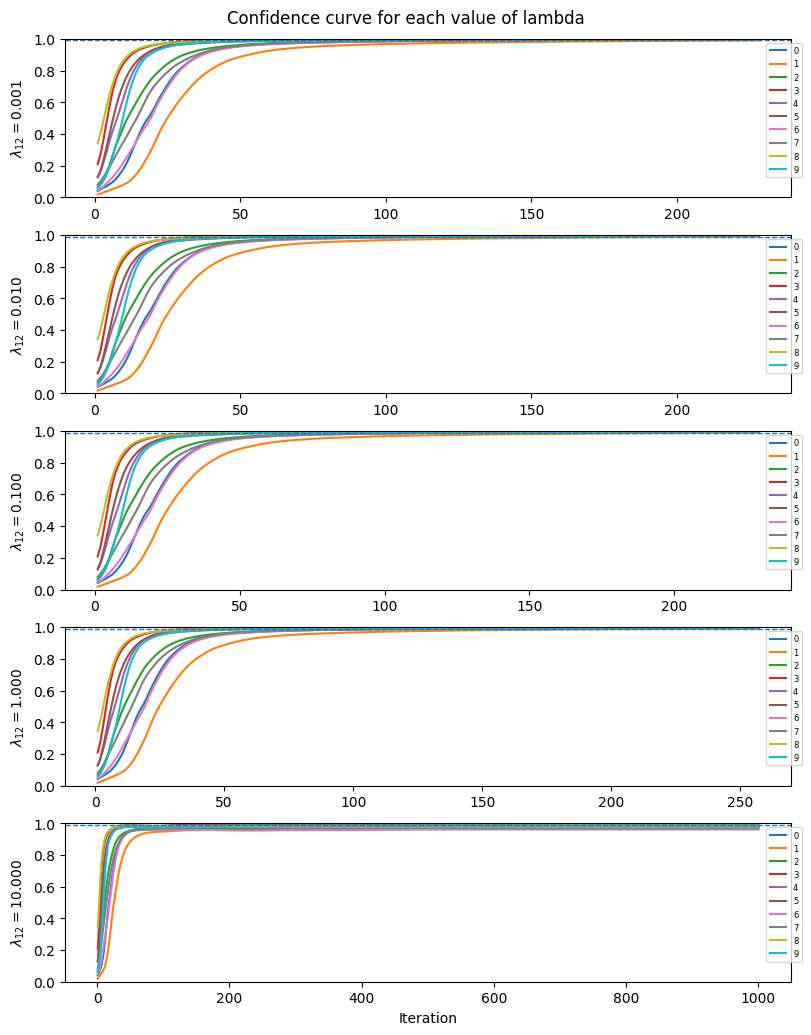

In [111]:
fig, axes = plt.subplots(
    len(lambda_values), 1,
    figsize=(8, 2 * len(lambda_values)),
    sharex=False,
    constrained_layout=True
)

for ax, lam, history in zip(axes, lambda_values, conf_histories):
    n_iters = history.shape[0]
    iters = np.arange(1, n_iters + 1)
    for digit in range(batch_size):
        ax.plot(iters, history[:, digit], label=str(digit))
    ax.axhline(threshold, linestyle='--', linewidth=1)
    ax.set_ylabel(f"$\\lambda_{{12}}={lam:.3f}$")
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.02, 1), fontsize=6, ncol=1)

axes[-1].set_xlabel("Iteration")
plt.suptitle("Confidence curve for each value of lambda", y=1.02)
plt.show()

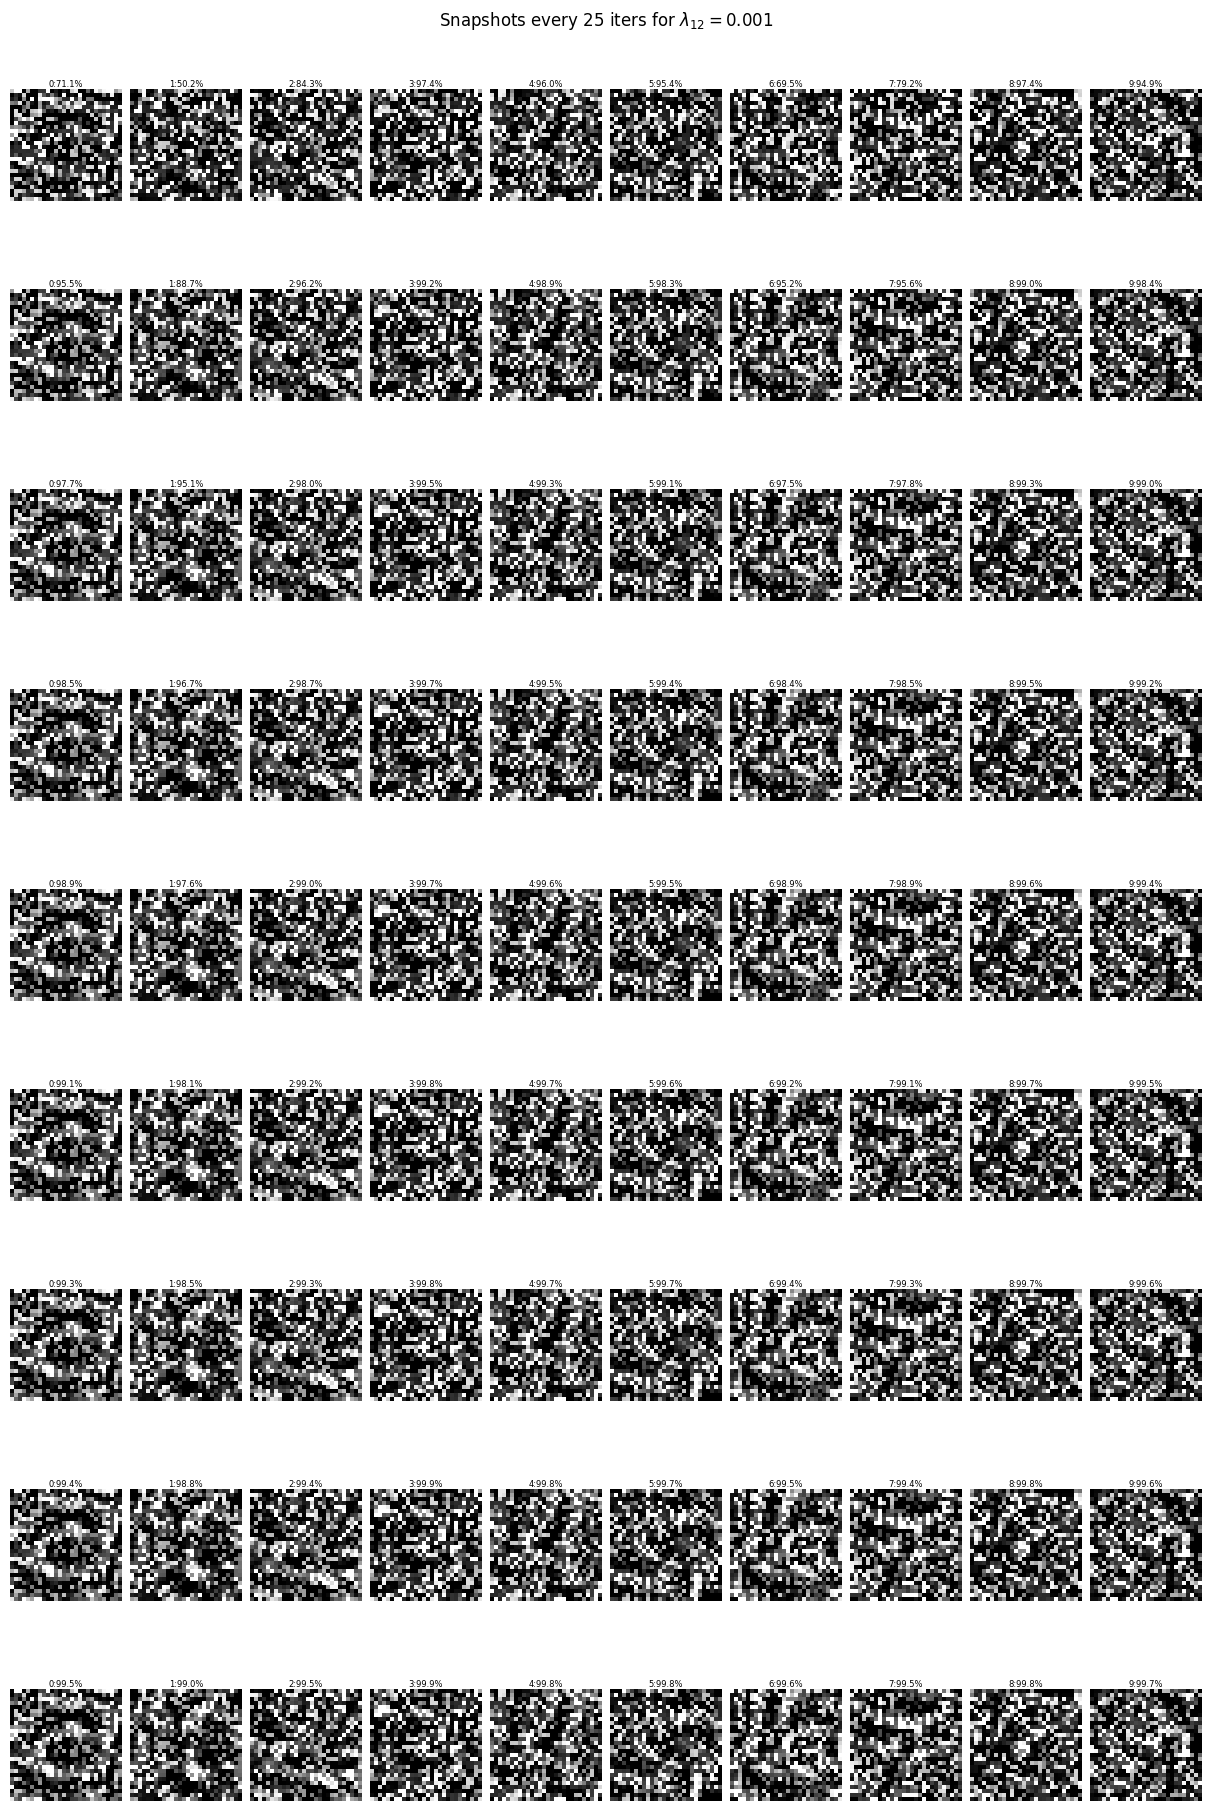

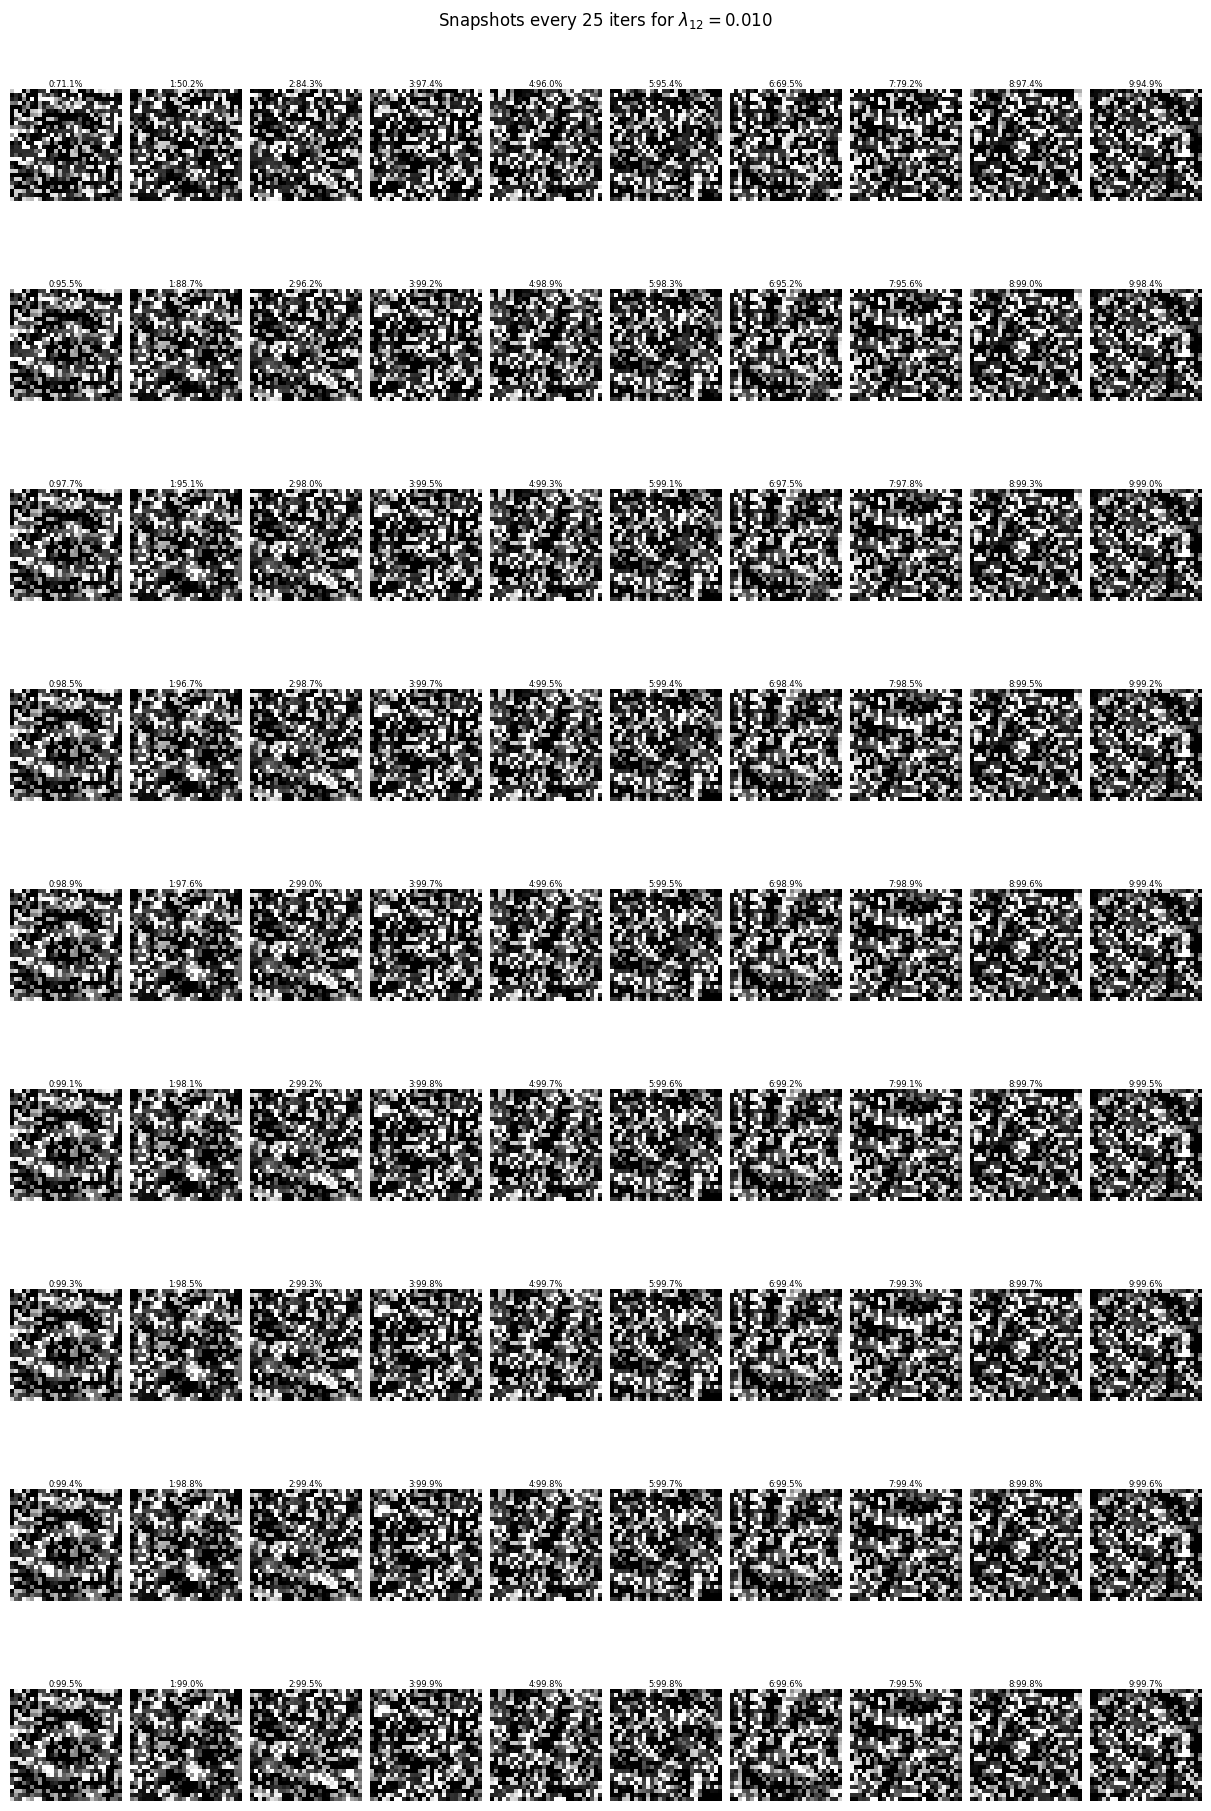

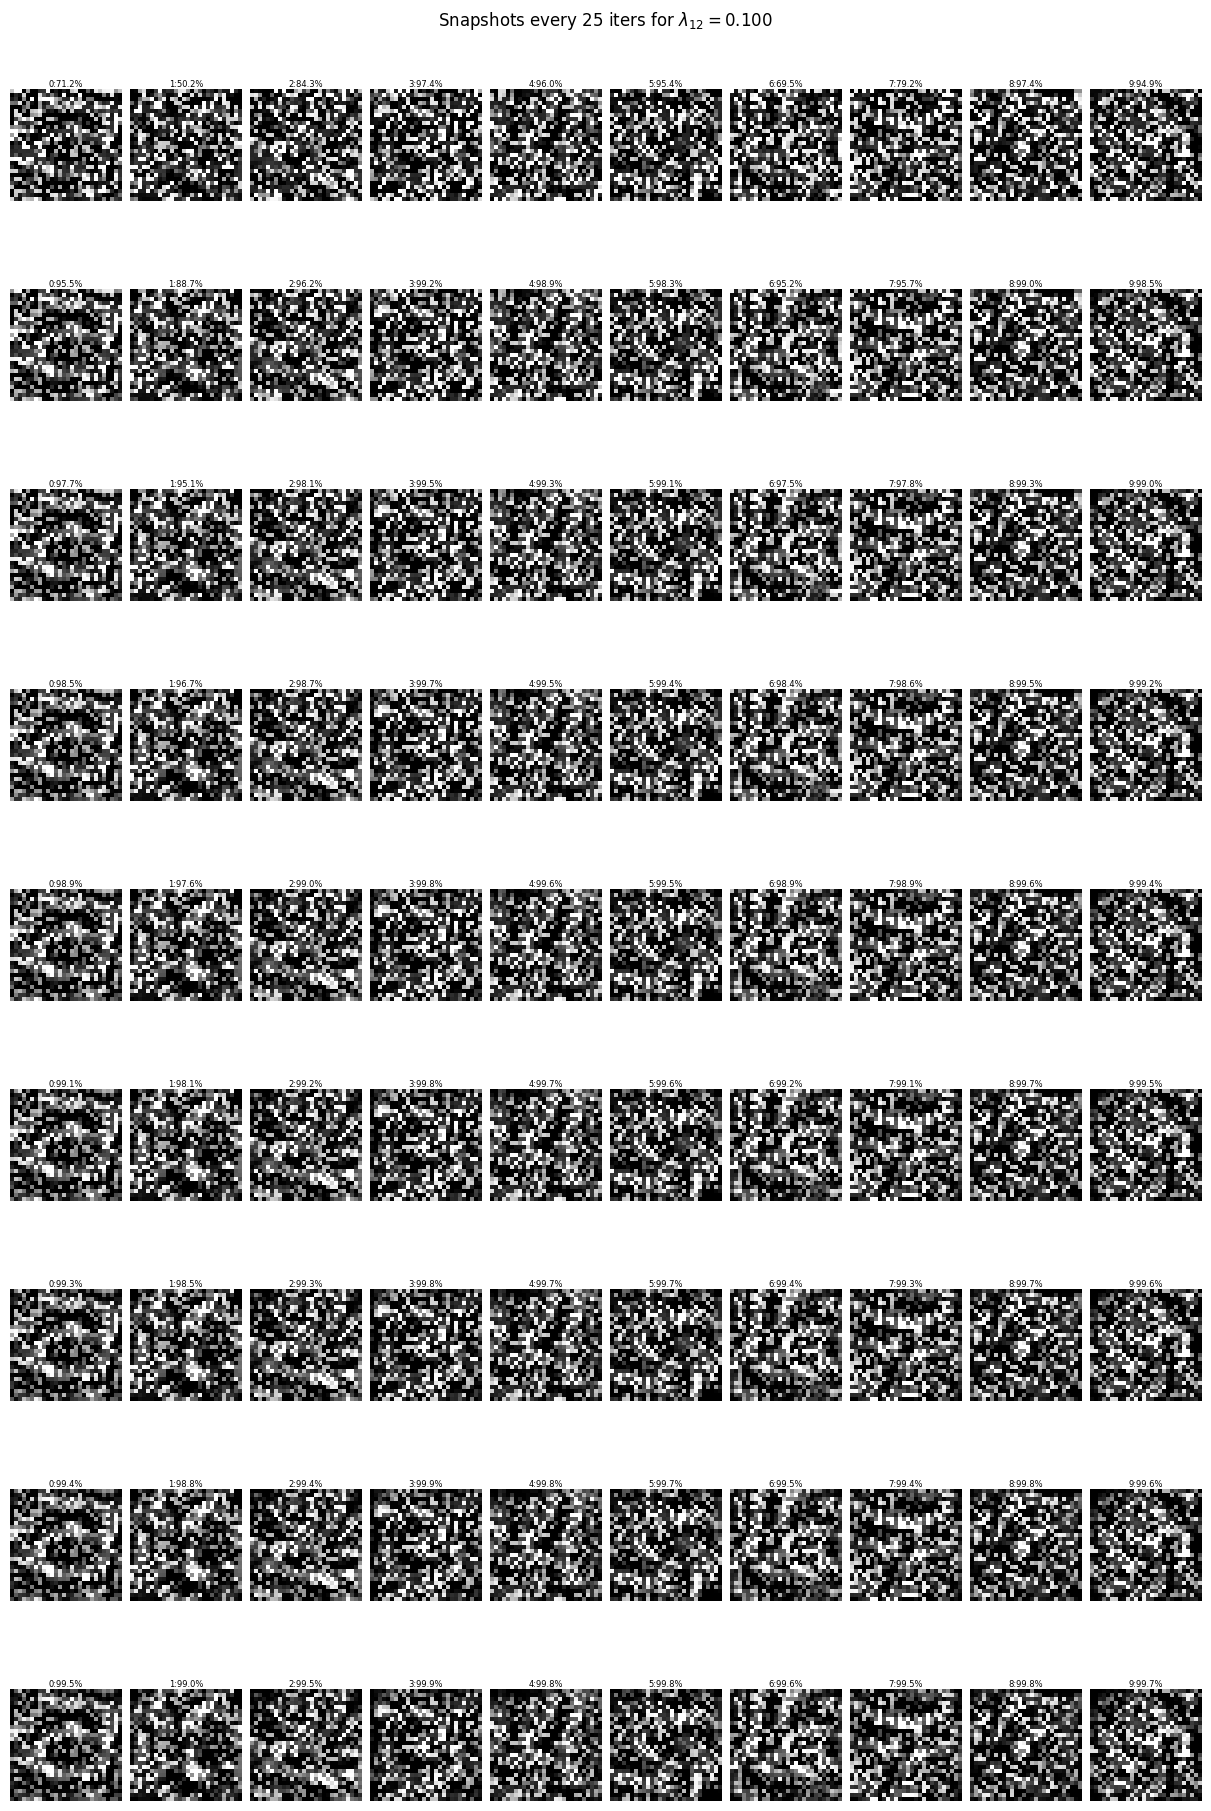

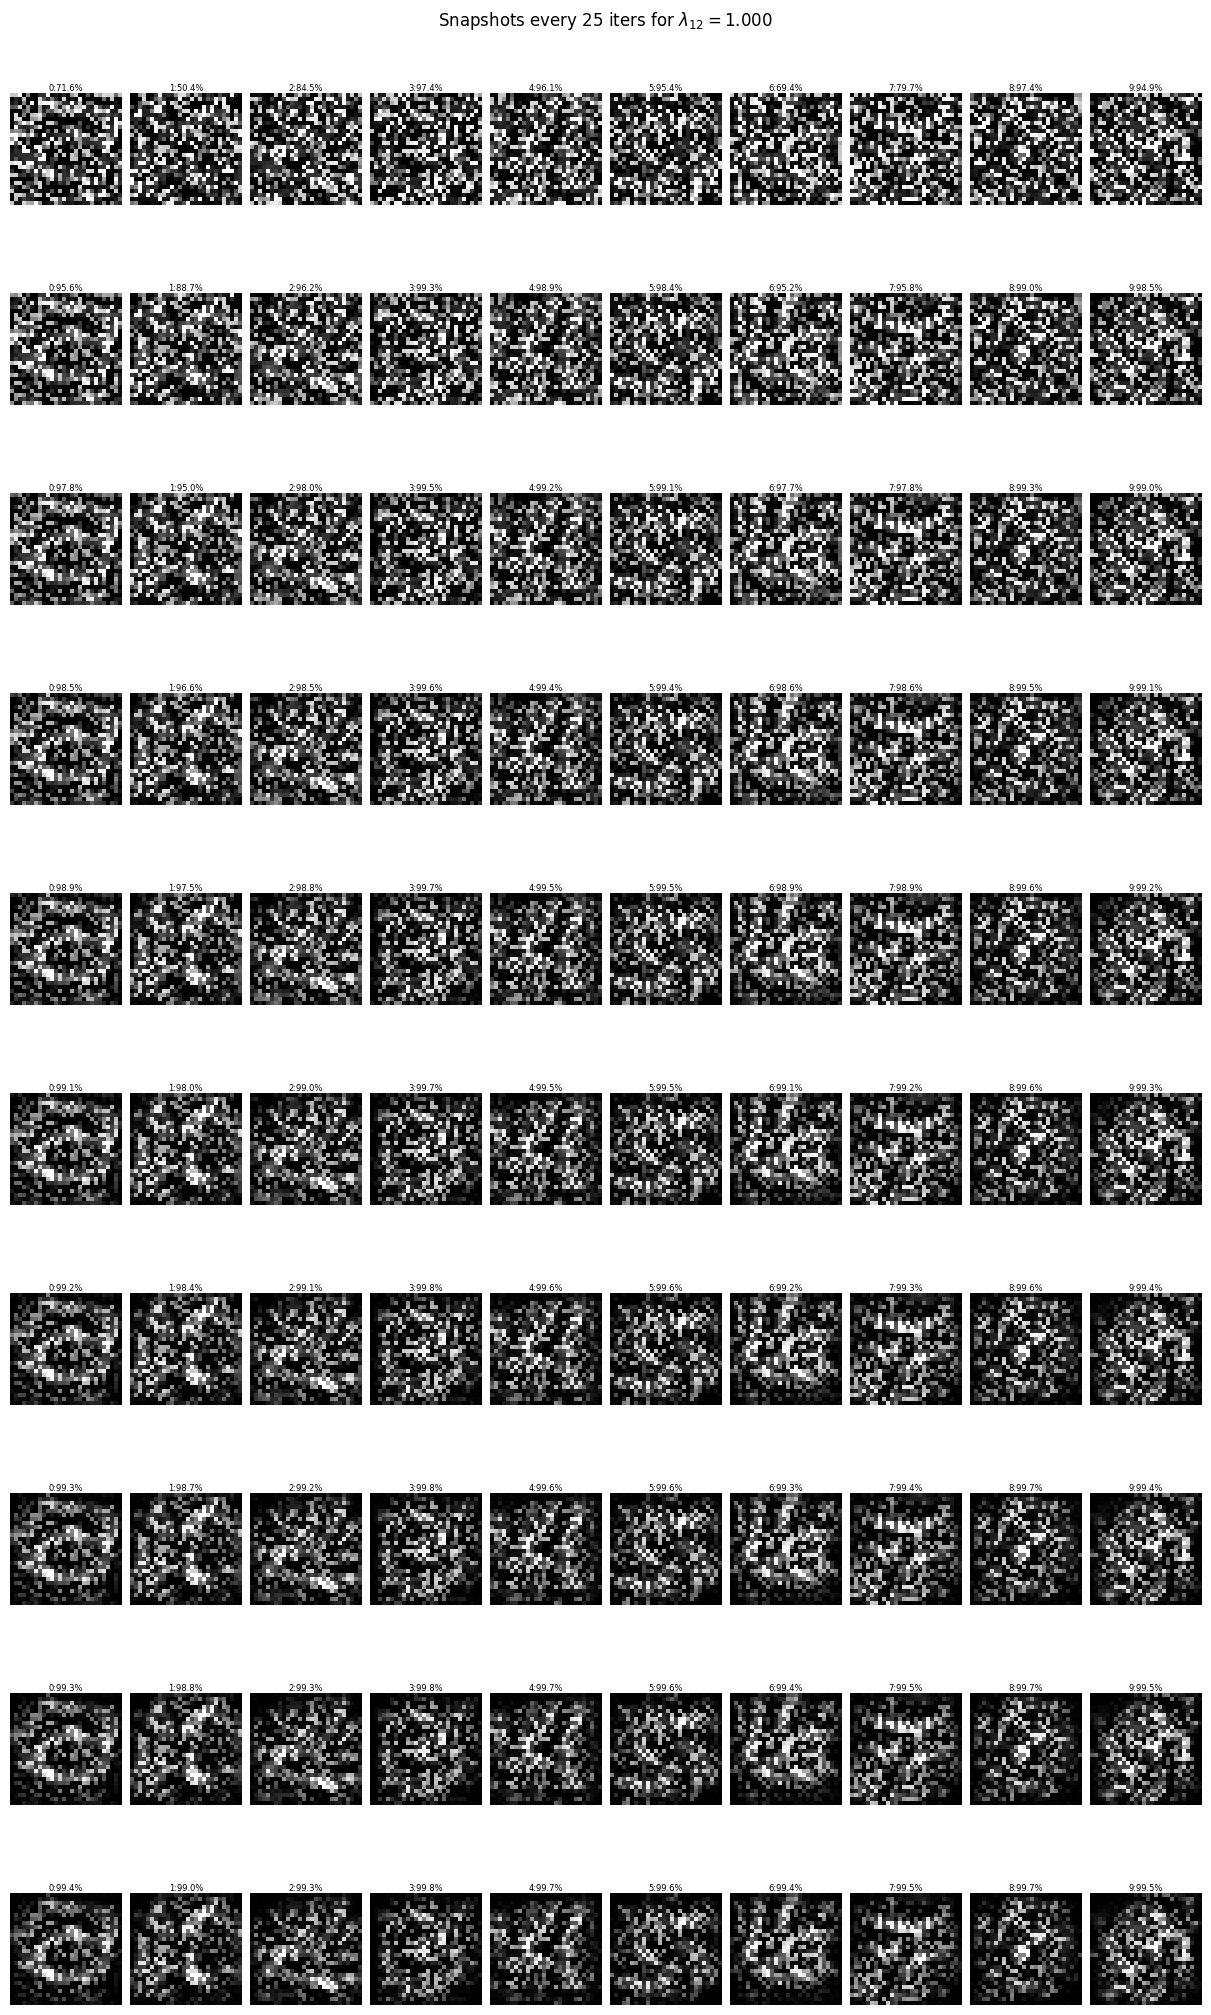

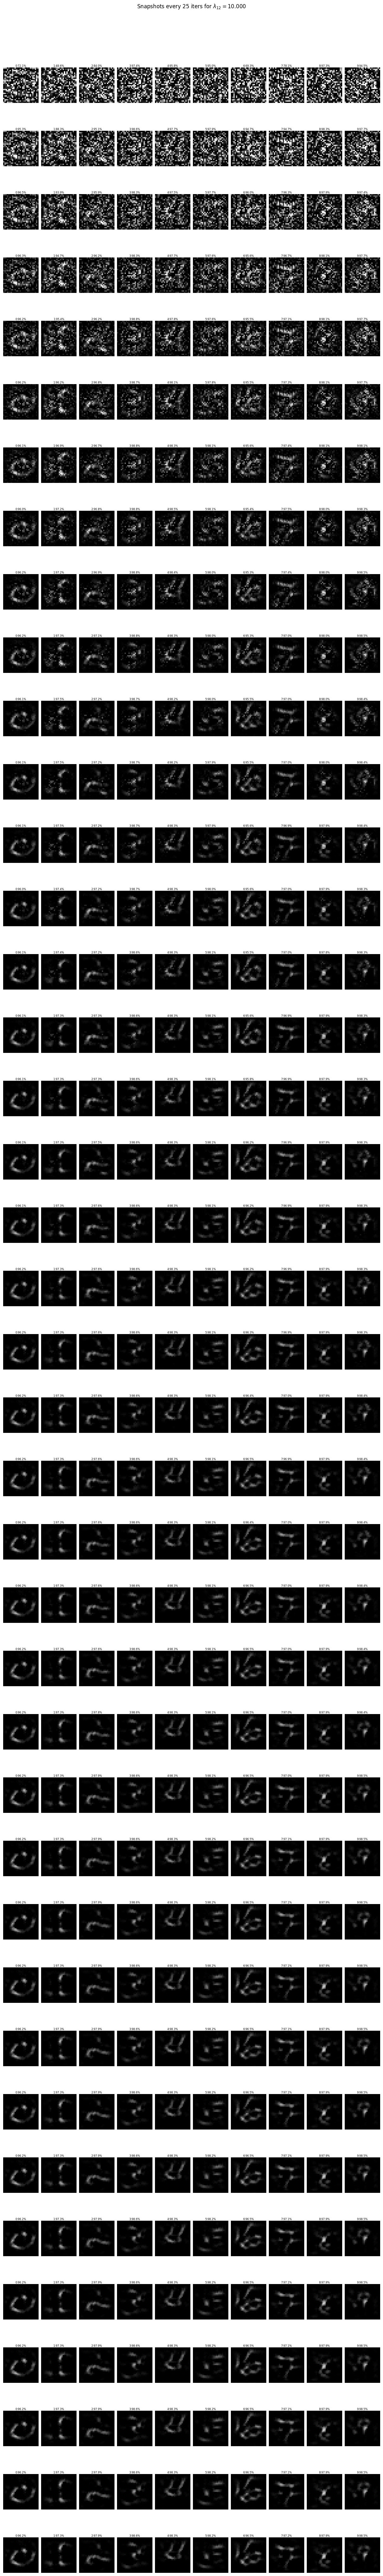

In [113]:
for idx, lam in enumerate(lambda_values):
    snaps = all_snapshots[idx]
    its   = all_snap_iters[idx]
    num_rows = len(snaps)

    fig, axes = plt.subplots(
        num_rows, batch_size,
        figsize=(12, 2 * num_rows),
        constrained_layout=True
    )

    for r, it in enumerate(its):
        # computing predictions & confidences for this snapshot row
        row_snaps = snaps[r].to(device)                 # shape [batch_size,1,28,28]
        with torch.no_grad():
            logits = model(row_snaps)                   # [batch_size,10]
            probs  = F.softmax(logits, dim=1)
            confs, preds = probs.max(dim=1)             # each shape [batch_size]

        confs = confs.cpu().numpy()
        preds = preds.cpu().numpy()

        for c in range(batch_size):
            ax = axes[r, c] if num_rows > 1 else axes[c]
            ax.imshow(snaps[r][c].squeeze(), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
            ax.set_title(f"{preds[c]}:{confs[c]*100:.1f}%", fontsize=6, pad=2)
        axes[r, 0].set_ylabel(f"Iter {it}", rotation=0, labelpad=20, va='center')

    fig.suptitle(fr"Snapshots every 25 iters for $\lambda_{{12}}={lam:.3f}$", y=1.02)
    plt.show()

## Questions:  Are the new digits recognized correctly? How does the penalty impact the digit quality?

Even under a strong $L_2$ penalty, the “dreamed” images are correctly classified by the frozen MNIST network as their intended digits, albeit with lower peak confidence. For example, with $\lambda_{12}=10$ the classifier never quite reaches 99 % probability in 1000 iterations, but its top prediction still matches the target label for each image. This shows that the network’s learned feature detectors still fire on the broader, smoother strokes—even though the regularizer prevents the extreme pixel adjustments that would drive confidence higher.

As we increase the penalty strength, the visual quality of the digits improves dramatically: speckled adversarial noise gives way to coherent shapes that a human can readily identify. However, because every pixel value now incurs a quadratic cost, the optimizer cannot push the target logit as far above the rest, so the classifier’s probability peaks at a lower value, despite the fact that the images themselves are of better quality.








We will now repeat the second task with the newly introduced penalties. Aside from that, out method remains the same as in the unpenalized scenario. We will be working with 3 and 8 again.

λ=0.001: reached 99% at iter 42
λ=0.010: reached 99% at iter 42
λ=0.100: reached 99% at iter 42
λ=1.000: reached 99% at iter 47
λ=10.000: stopped at 1000 iters; final confs = { 3:98.8%, 8:99.0% }


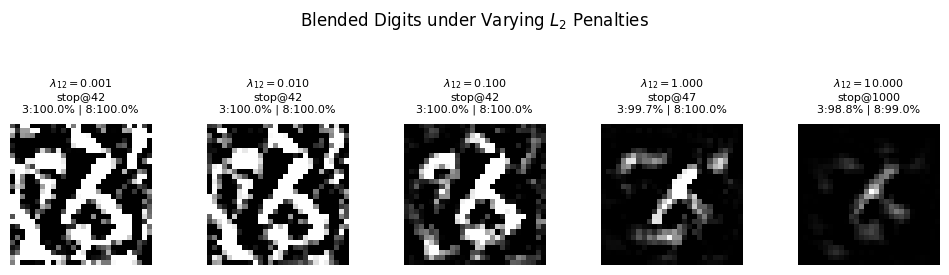

In [131]:
# Settings
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_digits = [3, 8]                 # digits to blend
num_classes   = 10
lr            = 0.01
max_iters     = 1000
threshold     = 0.99
lambda_values = np.logspace(-3, 1, 5)  # [0.001, 0.01, 0.1, 1, 10]

# Storage
final_images = []
final_confs  = []
end_iters    = []

# Sweeping over L2 penalties grid
for lambda_12 in lambda_values:
    # Reseed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Initializing noise image and multi-hot labels
    dreamed2 = torch.randn(1, 1, 28, 28, device=device, requires_grad=True)
    labels   = torch.zeros(num_classes, device=device)
    labels[target_digits] = 1.0

    # Setting up optimizer and loss
    optimizer = torch.optim.Adam([dreamed2], lr=lr)
    bce_loss  = torch.nn.BCEWithLogitsLoss()
    reached   = False

    # Optimization loop
    for it in range(1, max_iters+1):
        optimizer.zero_grad()
        logits = model(dreamed2).squeeze(0)
        loss   = bce_loss(logits, labels) \
               + lambda_12 * dreamed2.pow(2).mean()
        loss.backward()
        optimizer.step()
        dreamed2.data.clamp_(0, 1)

        # Checking sigmoid confidences
        with torch.no_grad():
            probs = torch.sigmoid(logits)
            confs = probs[target_digits]
        if not reached and (confs >= threshold).all():
            print(f"λ={lambda_12:.3f}: reached {threshold*100:.0f}% at iter {it}")
            end_iters.append(it)
            reached = True

    if not reached:
        print(f"λ={lambda_12:.3f}: stopped at {max_iters} iters; "
              f"final confs = {{ {target_digits[0]}:{probs[target_digits[0]]*100:.1f}%, "
              f"{target_digits[1]}:{probs[target_digits[1]]*100:.1f}% }}")
        end_iters.append(max_iters)

    # Record final image & full confidence vector
    final_images.append(dreamed2.detach().cpu().clone())
    final_confs.append(probs.cpu().numpy())

fig, axes = plt.subplots(
    1, len(lambda_values),
    figsize=(2 * len(lambda_values), 2.5),
    constrained_layout=False  # we’ll call tight_layout with a rect
)

for ax, img, confs, lam, ei in zip(axes, final_images, final_confs, lambda_values, end_iters):
    ax.imshow(img.squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    # Column‐title with λ and stop iteration
    ax.set_title(
        rf"$\lambda_{{12}}={lam:.3f}$" + "\n" +
        rf"stop@{ei}" + "\n" +
        rf"{target_digits[0]}:{confs[target_digits[0]]*100:.1f}% | "
        rf"{target_digits[1]}:{confs[target_digits[1]]*100:.1f}%",
        fontsize=8,
        pad=8
    )

# Main title, moved up
fig.suptitle(
    "Blended Digits under Varying $L_2$ Penalties",
    fontsize=12,
    y=1.08
)

# Make room for the suptitle and column titles
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


Across the exponential sweep of $L_2$ penalties, the classifier continues to correctly recognize each dreamed image as its target digit, even when the softmax confidence is below our 99 % threshold. With very light regularization (lambda values between 0.001 and 0.1), the network achieves full confidence rapidly, but the resulting images remain noisy and it is difficult to make out any handwritten digits there. As we increase lambda toward 1, the optimizer is forced to trade off absolute confidence for smoother pixel configurations, yielding images that reveal the familiar loops and strokes of real digits while still attaining high (≈ 99 %) probability. At the strongest penalty of 10, the classifier peaks at about 99% (a bit below that in the case of 3) confidence, lower than in the previous cases, but the visuals somewhat resemble 8 (or 3). In sum, the $L_2$ penalty sharpens the human interpretability of the dreamed digits at the expense of a slight drop in network certainty.